## Parameters

In [1]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta

lens_model = "filvm"  # either filvm or ilvm

save_loc = "saved/basic_mnist"
ae_loc = save_loc
data_loc = save_loc

BATCH_SIZE = 32
root_logdir = save_loc + "/logs"


## Full 
reps = 5
epochs = 100 
EARLY_STOP = 4
flow_depth_options = [5, 10, 15]
inter_dims_options = [[1024, 128, 32], ]
optimizer_options = [Adam(), RMSprop()]
beta_options = [0.2, 0.5, 0.8, 1.0]
gamma_options = [2.0, 1.0]


## Quick 
reps = 1 
epochs = 2 
EARLY_STOP = 2
flow_depth_options = [5]
inter_dims_options = [[1024, 128, 32], ]
optimizer_options = [Adam()]
beta_options = [0.5]
gamma_options = [2.0]



## Mid 

lens_model = "ilvm" 
reps = 3
epochs = 100 
EARLY_STOP = 4
flow_depth_options = [10]
inter_dims_options = [[1024, 128, 32], ]
optimizer_options = [Adam(), RMSprop()]
beta_options = [0.2, 0.5, 0.8,]
gamma_options = [2.0, 1.0]

## Imports

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy


from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
import time

from my_lib.save_load import load_datasets, load_models, save_ilvm
# from my_lib.models.vae_sequence import START, SCALE
from my_lib.models.common_functions import sampling2, Linear, log_normal_pdf
from my_lib.models.planar_flows import PlanarFlow
from my_lib.models.filvm import FILVM 
from my_lib.helpers import walk_ld, make_plots, make_id, param_search_to_list

## Custom Layers

In [3]:
all_models = load_models(ae_loc)

In [4]:
all_data = load_datasets(data_loc)

In [5]:
for name, model in all_models.items():
    exec("{} = model".format(name))
    print("initialized variable,", name)

initialized variable, vae_mlp
initialized variable, encoder
initialized variable, decoder


In [6]:
for name, model in all_data.items():
    name = name.split(".")[0]
    exec("{} = model".format(name))
    print("initialized variable,", name)

initialized variable, thicks_d_test
initialized variable, raw_thick_scores
initialized variable, thicks_q_test
initialized variable, y_train
initialized variable, raw_thick_scores_test
initialized variable, y_test
initialized variable, x_test
initialized variable, x_train
initialized variable, thicks_q
initialized variable, thicks_d


In [7]:
# ensure data is normalized
if np.max(x_train) > 200.:
    x_train = x_train/255.
    x_test = x_test/255.

## Set up ilvm training data

In [8]:
# Pick which thick scores to use as side info. 
use_thicks = thicks_q
use_thicks_test = thicks_q_test

In [9]:
z_train, _, _ = encoder(x_train)
latent_dim = z_train.shape[1]
z_train

<tf.Tensor: shape=(60000, 8), dtype=float32, numpy=
array([[-0.69223934, -1.8289407 , -0.5659856 , ...,  0.4380339 ,
        -0.18506259,  0.44461358],
       [ 1.1612247 , -0.9193869 ,  0.1622806 , ...,  0.9053518 ,
        -0.20917724, -0.44360903],
       [-0.56246805,  0.64449376,  0.05930495, ..., -1.395544  ,
         2.2240386 , -0.7475901 ],
       ...,
       [ 0.3188441 , -2.72668   , -0.35381925, ..., -0.6959816 ,
         0.2286529 ,  1.2656709 ],
       [ 1.5745815 , -1.1095915 , -0.3641129 , ..., -1.1433784 ,
        -0.996116  , -1.9392468 ],
       [-0.37015447, -0.1851908 ,  0.28137153, ..., -0.818171  ,
         0.26555163, -0.3438447 ]], dtype=float32)>

In [10]:
z_train1, z_train2, s_digit1, s_digit2, s_thick1, s_thick2 = train_test_split(z_train.numpy(), y_train, 
                                                                              use_thicks, test_size=0.5)


z_train1 = tf.constant(z_train1, dtype=tf.float32)
z_train2 = tf.constant(z_train2, dtype=tf.float32)
s_digit1 = tf.one_hot(s_digit1, depth=10)
s_digit2 = tf.one_hot(s_digit2, depth=10)
s_thick1 = tf.constant(s_thick1, dtype=tf.float32)
s_thick2 = tf.constant(s_thick2, dtype=tf.float32)

#### And test data

In [11]:
z_test, _, _ = encoder(x_test)

s_digit_test = tf.one_hot(y_test, depth=10)
s_thick_test = tf.constant(use_thicks_test, dtype=tf.float32)

In [12]:
# Constants
s_dim = 10 + 1
input_s_shape = (s_dim , )
input_z_shape = (latent_dim, )
batch_size = 32

flow_dim = latent_dim
z_dim = latent_dim

shuf_size = (s_thick1.shape[0]//batch_size) *batch_size

#### Make datasets

In [13]:
ds1 = tf.data.Dataset.from_tensor_slices((z_train1, s_digit1, s_thick1)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds1

<BatchDataset shapes: ((32, 8), (32, 10), (32,)), types: (tf.float32, tf.float32, tf.float32)>

In [14]:
ds2 = tf.data.Dataset.from_tensor_slices((z_train2, s_digit2, s_thick2)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds2

<BatchDataset shapes: ((32, 8), (32, 10), (32,)), types: (tf.float32, tf.float32, tf.float32)>

In [15]:
ds_test = tf.data.Dataset.from_tensor_slices((z_test, s_digit_test, s_thick_test)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds_test

<BatchDataset shapes: ((32, 8), (32, 10), (32,)), types: (tf.float32, tf.float32, tf.float32)>

# Build ILVM model 

### loss_fn

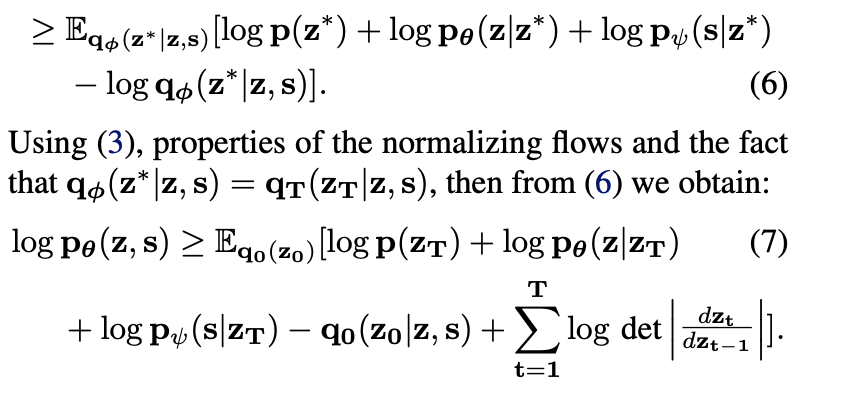

In [16]:
from tensorflow.keras.losses import MSE, categorical_crossentropy
def multinomial_loss_function(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t, beta=1.0, gamma=1.0): 
    """
    :param z_pred: shape: (batch_size, latent_dim), real valued, mean of p_theta(z|z*)
    :param z:       shape (batch_size, latent_dim), original z
    
    :param s_logit: shape: (batch_size, s_digit_dim + s_rot_dim), real valued logits, first 10 cols contain digit, rest are rot
    :param s:       shape: (batch_size, s_digit_dim + s_rot_dim), concated one-h encoding of digit and rot info
    
    :param z_0: first stochastic latent variable
    :param log_q_z0: log denisty of z_0
    
    :param z_t: last stochastic latent variable
    :param ldj: log det jacobian
    
    Note: elbo = log_p_zt + log_p_theta + log_p_psi - log_q_z0 + log_dets    [loss = -elbo]
    """
    log_p_zt = log_normal_pdf(z_t, mean=0.,  logvar=0.)
    
    log_p_theta = log_normal_pdf(z, mean=z_pred, logvar=0.) 
    
    digit_p = -categorical_crossentropy(s[0], s_pred[0], from_logits=True)
    thick_p = log_normal_pdf(s[1], mean=s_pred[1], logvar=0.) #-categorical_crossentropy(s[1], s_pred[1], from_logits=True)
    log_p_psi = digit_p + thick_p
     
    
    recons_loss = -(log_p_theta*gamma + log_p_psi)
    kl_loss = log_q_z0 - log_dets - log_p_zt


    loss = recons_loss + kl_loss*beta
    return tf.reduce_mean(loss)
  


def lf_reconstr_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t): 
    log_p_theta = log_normal_pdf(z, mean=z_pred, logvar=0.)
    
    digit_p = -categorical_crossentropy(s[0], s_pred[0], from_logits=True)
    rot_p = log_normal_pdf(s[1], mean=s_pred[1], logvar=0.)
    log_p_psi = tf.add(digit_p, rot_p)

    loss = -tf.reduce_mean(log_p_theta + log_p_psi)
    return loss


def lf_kl_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t): 
    log_p_zt = log_normal_pdf(z_t, mean=0.,  logvar=0.)
    loss = log_q_z0 - log_dets - log_p_zt
    return tf.reduce_mean(loss)


    
metrics = []
metrics.append(('reconstr_loss', lf_reconstr_loss))
metrics.append(('kl_loss', lf_kl_loss))
metrics

[('reconstr_loss',
  <function __main__.lf_reconstr_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t)>),
 ('kl_loss',
  <function __main__.lf_kl_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t)>)]

In [17]:
def build_lens_model(model_type = "filvm",
               latent_dim = 2, 
               flow_depth = 5, 
               inter_dims = [1024, 256, 16], 
               optimizer = tf.keras.optimizers.Adam(), 
               metrics = [], 
               loss_fn = None, 
               beta=1.0, 
               gamma=1.0, 
              ):
    """
    Creates lens model (ilvm or filvm)
    
    
    :param model_type: (str) type of lens model ("ilvm" or "filvm")
    :param latent_dim: (int) size of latent dimension
    :param flow_depth: (int) number of layers of planar flows to use
    :param inter_dims: (list of ints) sizes of each intermediate layer in models [same architecture used for different models]
    :param optimizer: an optimizer from tf.keras.optimizers
    :param metrics: (list of functions) metrics to track while training
    :param loss_fn: (function) loss function to use (should be multinomial_loss_function)
    :param beta: (float) parameter controling relative strenght of kl objective
    :param gamma: (float) parameter controling relative strenght of reconstructing z objective

    """

    input_z = Input(shape=(z_dim, ), batch_size=batch_size,name='z_in')
    input_s_d = Input(shape=(10, ), batch_size=batch_size,name='s_dig_in')
    input_s_t = Input(shape=(s_dim - 10), batch_size=batch_size,name='s_thc_in')

    recnet1_in = [input_z, input_s_d, input_s_t]
    recnet1_in_cc = tf.keras.layers.concatenate(recnet1_in, axis=1)


    #############  Recnet 1 ##############
    x = Dense(inter_dims[0], activation='relu')(recnet1_in_cc)
    for dim in inter_dims[1:]:
        x = Dense(dim, activation='relu')(x)
    

    w = Dense(flow_dim * flow_depth, name='w')(x)
    u = Dense(flow_dim * flow_depth, name='u')(x)
    b = Dense(1 * flow_depth, name='b')(x)


    z0_mean = Dense(z_dim, name='z0_mean')(x)
    z0_log_var = Dense(z_dim, name='z0_log_var')(x)
    z0, log_q0 = Lambda(sampling2, output_shape=(z_dim,), name='z_0')([z0_mean, z0_log_var])

    recnet1 = Model(recnet1_in, [z0_mean, z0_log_var, z0, log_q0, w, u, b], name='recnet1')


    #############  Srn ##############
    x = Dense(inter_dims[0], activation='relu')(input_z)
    for dim in inter_dims[1:]:
        x = Dense(dim, activation='relu')(x)

    s_d_out = Dense(10, name='s_dig_out',activation="softmax")(x)
    s_t_out = Dense(s_dim-10, name='s_thc_out')(x)

    srn = Model(input_z, (s_d_out, s_t_out), name='srn')


    #####                      Flow             #####   
    pf_layers = [PlanarFlow() for _ in range(flow_depth)]

    
    #####                  Generative model             #####  
    if model_type.lower() == "filvm":
        gen_inputs1 = Input(shape=(z_dim,), batch_size=32, name='zt_full')
        gen_inputs2 = Input(shape=(z_dim,), batch_size=32, name='zt_0')
        gen_inputs3 = Input(shape=(z_dim,), batch_size=32, name='zt_1')

        # theta part
        x = Dense(inter_dims[-1], activation='relu', name="gm_theta_1")(gen_inputs1)
        for dim in reversed(inter_dims[:-1]):
            x = Dense(dim, activation='relu')(x)

        output_z = Dense(z_dim, name="gm_theta_4")(x)  

        # psi part
        output_s_d = Linear(input_dim=1, output_dim=10, name="digit_pred")(tf.expand_dims(gen_inputs2[:,0],axis=1))
        output_s_t = Linear(input_dim=1, output_dim=s_dim-10, name="thick_pred")(tf.expand_dims(gen_inputs3[:,1],axis=1))

        # instantiate generative model
        gm1 = Model(gen_inputs1, output_z, name='generative_model1')
        gm2 = Model(gen_inputs2, output_s_d, name='generative_model2')
        gm3 = Model(gen_inputs3, output_s_t, name='generative_model3')

    elif model_type.lower() == "ilvm":

        gen_inputs1 = Input(shape=(z_dim,), batch_size=32, name='zt_full')

        # theta part
        x = Dense(inter_dims[-1], activation='relu', name="gm_theta_1")(gen_inputs1)
        for dim in reversed(inter_dims[:-1]):
            x = Dense(dim, activation='relu')(x)

        output_z = Dense(z_dim, name="gm_theta_4")(x)  

        # psi part
        output_s_d = Linear(input_dim=z_dim, output_dim=10, name="digit_pred")(gen_inputs1)
        output_s_t = Linear(input_dim=z_dim, output_dim=s_dim-10, name="thick_pred")(gen_inputs1)

        # instantiate generative model
        gm1 = Model(gen_inputs1, output_z, name='generative_model1')
        gm2 = Model(gen_inputs1, output_s_d, name='generative_model2')
        gm3 = Model(gen_inputs1, output_s_t, name='generative_model3')
        
    else:
        raise Exception("Invalid model type!, must be 'filvm' or 'ilvm', got {}".format(model_type))
    
    gm = (gm1, gm2, gm3)
    
    ## Create model ##
    ilvm = FILVM(recnet1, srn, pf_layers, gm,  optimizer, beta=beta, gamma=gamma)
    ilvm.set_metrics(metrics)
    ilvm.set_loss_fn(multinomial_loss_function)
    
    return ilvm
    


In [18]:
ilvm = build_lens_model(loss_fn=multinomial_loss_function, metrics=metrics)
z_dim

8

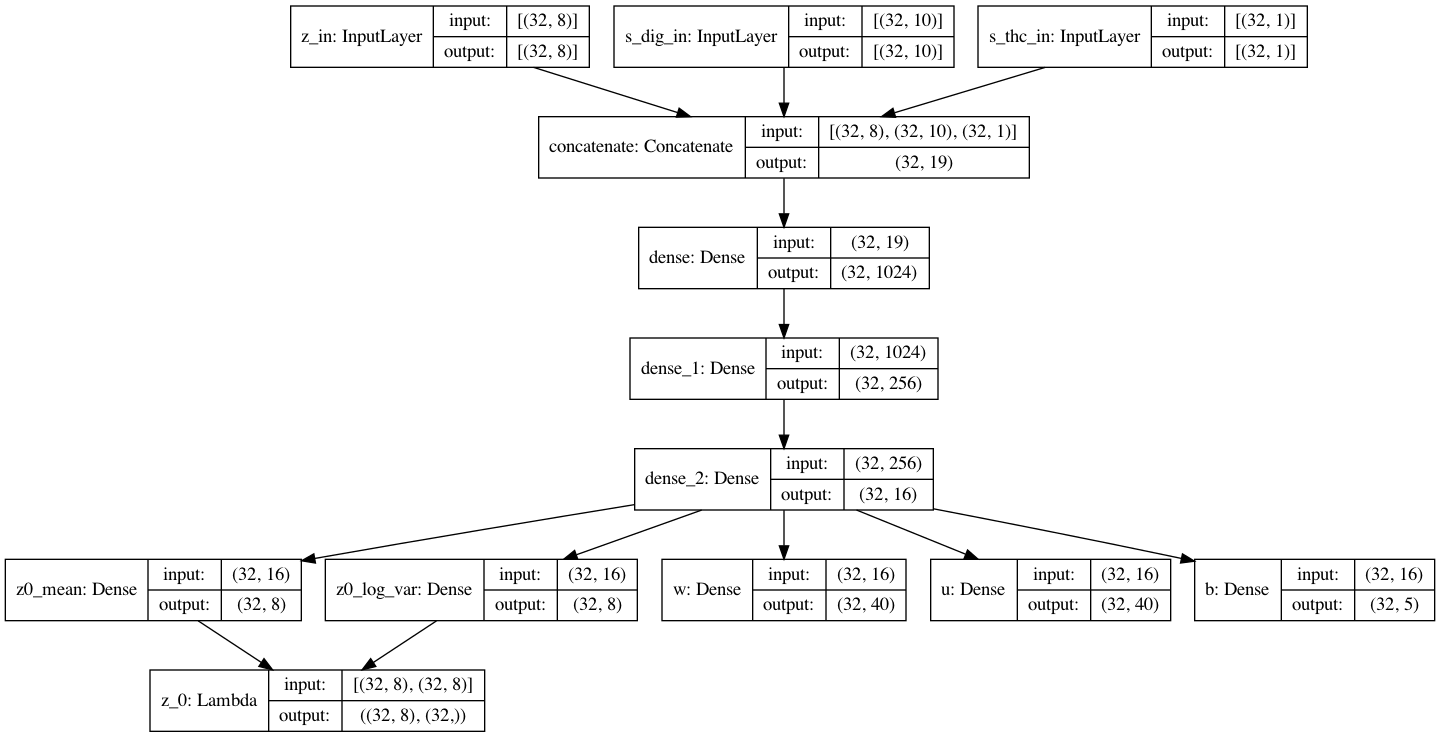

In [19]:
plot_model(ilvm.recnet, show_shapes=True)

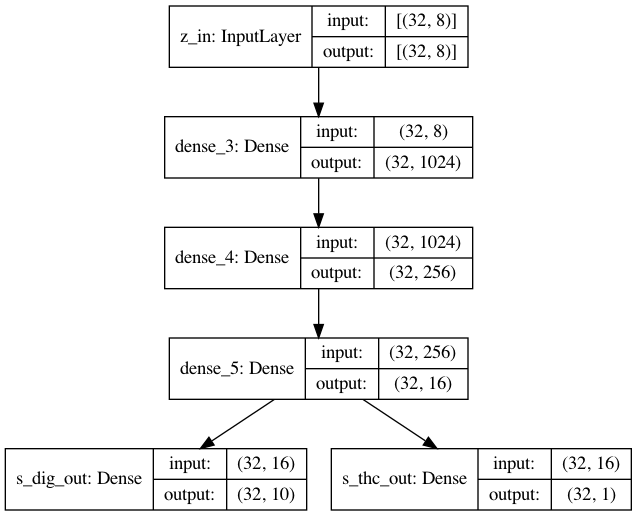

In [20]:
plot_model(ilvm.srn, show_shapes=True)

In [21]:
# Planar flows

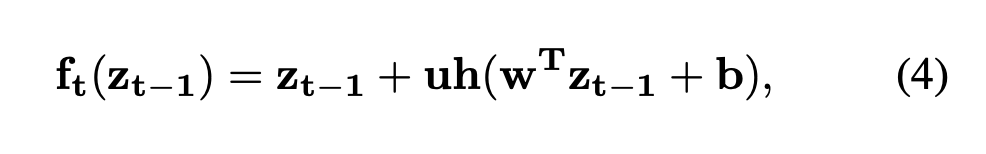 

h is tanh; w,u are vectors; b is scalar

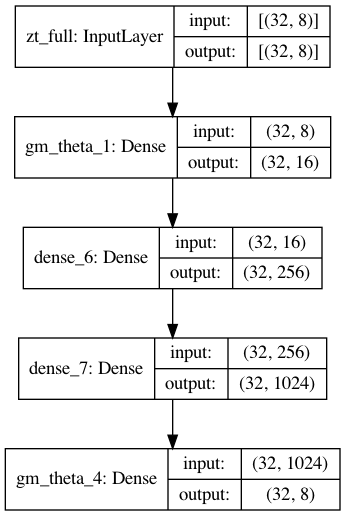

In [22]:
plot_model(ilvm.gm1, show_shapes=True)

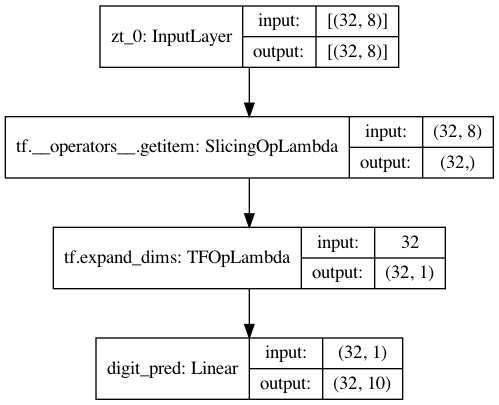

In [23]:
plot_model(ilvm.gm2, show_shapes=True)

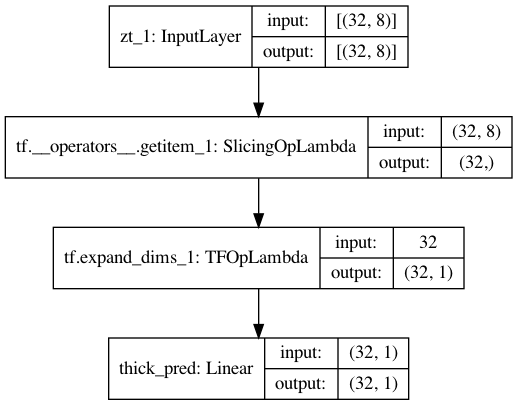

In [24]:
plot_model(ilvm.gm3, show_shapes=True)

In [25]:
param_search = dict(flow_depth = flow_depth_options, 
                     inter_dims = inter_dims_options, 
                     optimizer = optimizer_options, 
                     beta= beta_options, 
                     gamma= gamma_options)




param_list = param_search_to_list(param_search)
len(param_list), param_list[0]

(12,
 {'gamma': 2.0,
  'beta': 0.2,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x104eff160>,
  'inter_dims': [1024, 128, 32],
  'flow_depth': 10})

In [26]:
trained = []

In [ ]:
watch =["cv_full_loss"]

for rep in range(reps):
    for params in param_list:
        for w in watch:

            id_str = make_id(params) + "--{}--{}".format(w, rep)
            print("running:", id_str)

            log_dir = "{}/{}".format(root_logdir, id_str)
            os.makedirs(log_dir, exist_ok=True)

            ilvm = build_lens_model(model_type=lens_model, **params,loss_fn=multinomial_loss_function, metrics=metrics)

            trained.append((id_str, ilvm)) 

            ilvm.fit(epochs, log_dir, ds1=ds1, ds2=ds2, ds_test=ds_test, batch_size=BATCH_SIZE,
                      show=False, plot_freq=5, early_stop=EARLY_STOP, watch=w)
            
#             walk_ld(ilvm, xrng= (-3, 3), yrng = (-3, 3), n= 60, figsize=(16, 16), model_name=log_dir )
            
#             n_ep = len(ilvm.track["tr1_full_loss_noc"])
            
#             make_plots((z_test, s_digit_test, s_thick_test), ilvm, log_dir, n_ep,
#                    prefixs=["digit", "thick_d", "thick_raw"], cs=[y_test, thicks_d_test, raw_thick_scores_test])

#             make_plots(z_test, ilvm, log_dir, n_ep, 
#                prefixs=["digit (no s)", "thick_d (no s)", "thick_raw (no s)"], cs=[y_test, thicks_d_test, raw_thick_scores_test])
            

running: dep-10--inr-1024_128_32--opt-Adam--b-0_2--g-2_0--cv_full_loss--0
Epoch 1 Batch 0 Loss 1 541.4321
tr1_reconstr_loss 530.80115
tr1_kl_loss 0.37265962


Epoch 1 Batch 0 Loss 2 479.3098
tr2_reconstr_loss 468.3277
tr2_kl_loss -0.0046574175
tr2_loss_srn_d 0.090247385
tr2_loss_srn_t 26.953175
tr2_loss_srn 27.043423


Epoch 1 Loss 12569.2520
********** CV **********
Epoch 1 Loss 6347.9448
cv_reconstr_loss 182.8664
cv_kl_loss 21.991291
Epoch 2 Batch 0 Loss 1 195.4612
tr1_reconstr_loss 182.6101
tr1_kl_loss 21.767786


Epoch 2 Batch 0 Loss 2 200.9900
tr2_reconstr_loss 188.51355
tr2_kl_loss 21.030731
tr2_loss_srn_d 0.06560901
tr2_loss_srn_t 9.2751045
tr2_loss_srn 9.3407135


Epoch 2 Loss 11863.7285
********** CV **********
Epoch 2 Loss 6226.9307
cv_reconstr_loss 184.40497
cv_kl_loss 17.339794
Epoch 3 Batch 0 Loss 1 170.1352
tr1_reconstr_loss 158.65906
tr1_kl_loss 16.95236


Epoch 3 Batch 0 Loss 2 173.1336
tr2_reconstr_loss 161.79398
tr2_kl_loss 16.441597
tr2_loss_srn_d 0.03275208
tr2_loss

### View trained ilvm

In [ ]:

show = 4
key = "cv_full_loss"

def model_sort_key(x):
    try:
        id_str, model = x
        return min(model.track[key])
    except:
        return 1e10

    
    
for i, (id_str, model) in enumerate(sorted(trained, key=model_sort_key)):
    print(id_str)

    n_ep = len(model.track[key])

    make_plots((z_test, s_digit_test, s_thick_test), model, log_dir, n_ep,
           prefixs=["digit", "thick_d", "thick_raw"], cs=[y_test, thicks_d_test, raw_thick_scores_test])


    zt = make_plots(z_test, model, log_dir, n_ep, return_zt=True,
       prefixs=["digit (no s)", "thick_d (no s)", "thick_raw (no s)"], cs=[y_test, thicks_d_test, raw_thick_scores_test])

    yrng = np.max(zt[:, 1]), np.min(zt[:, 1])

    walk_ld(model, decoder=decoder, n= 60, figsize=(16, 16), yrng= yrng, model_name=log_dir )

    if i >show-2:
        break


### Save model

In [ ]:
# set find to an ID str
find = "dep-10--inr-1024_128_32--opt-Adam--b-0_7--k-0_5--g-2_0--cv_digit_loss--2" 

for id_str, ilvm in trained:
    if id_str == find:
        print("found it")
        n_ep = len(ilvm.track["cv_full_loss"])

        make_plots((z_test, s_digit_test, s_thick_test), ilvm, "", n_ep, save=False,
               prefixs=["digit", "thick_d", "thick_raw"], cs=[y_test, thicks_d_test, raw_thick_scores_test])


        make_plots(z_test, ilvm, "", n_ep, save=False,
               prefixs=["digit (no s)", "thick_d (no s)", "thick_raw (no s)"], cs=[y_test, thicks_d_test, raw_thick_scores_test])

        break

In [ ]:
save_ilvm(filvm, save_loc + "/lens_model")

# Explore ways to walk z* (NEW)

#### Extend above, get grid of points from z* use generative model to get approx z, then decode

The latent dimension of z∗ maximally informative about thickness is kept fixed whereas the latent
dimension maximally informative about the digit identity
is varied to produce the rest of the images throughout the
same row

In [ ]:
make_plots(z_test, model, "", 0, save=False, 
           prefixs=["digit", "thick_d", "thick_raw"], cs=[y_test, thicks_d_test, raw_thick_scores_test])

In [ ]:
walk_ld(model, decoder=decoder, yrng=(0.5,1.6), xrng=(0.01, 0.99), figsize=(18,18), n=40, model_name=save_loc)

In [ ]:
###     Set these based on above plot      ####
rows = [0, 10, 25, 39]
# col_dig is column:digit
col_dig = {0:6, 2:0, 6:2, 10:3, 15:5, 18:8, 25:1, 31:7, 36:9, 39:4}
#####       #####


n=40
yrng=(0.5,1.6) 
xrng=(0.01, 0.99)
dims = [0,1]
figsize=(10, 10)



cols = list(col_dig.keys())
digit_size = 28
figure = np.zeros((digit_size * len(rows) , digit_size * len(cols)))
norm = tfp.distributions.Normal(0, 1)
grid_x = norm.quantile(np.linspace(*xrng, n))
#     grid_y = norm.quantile(np.linspace(*yrng, n))
#     grid_x = np.linspace(*xrng, n)
grid_y = np.linspace(*yrng, n)[::-1]



for i, yi in enumerate(grid_y):
    if i in rows:
        i = rows.index(i)
        for j, xi in enumerate(grid_x):
            if j not in cols: continue

            z_t = tf.reshape(np.array([xi,yi] + [0]*(z_dim-2)), (1,z_dim))


            z_pred = model.gm1(z_t)
            digit = decoder(z_pred).numpy().reshape((28,28))


            j = col_dig[j]

            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=figsize)
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[{}]".format(dims[0]))
plt.ylabel("z[{}]".format(dims[1]))
plt.imshow(figure, cmap='Greys_r')
plt.show()